In [1]:
#To manage Data
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

#To manage some files
import pickle
import json

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

#To get requests from the API
import requests

#To get geolocations
from geopy.geocoders import Nominatim 


#To improve loops
from tqdm import tqdm

## Loading Data

In [2]:
names = pd.read_csv('Data/names.csv')
dfGrouped = pd.read_csv('Data/dfGrouped.csv')

In [3]:
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode('Singapore')
singLatitude = location.latitude
singLongitude = location.longitude
print('Singapore Latitude',singLatitude)
print('Singapore Longitude',singLongitude)

Singapore Latitude 1.357107
Singapore Longitude 103.8194992


In [4]:
sing_map = folium.Map(location=[singLatitude, singLongitude], zoom_start=13)

for lat, lng, label in zip(names.Latitude, names.Longitude, names.names):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(sing_map)

sing_map

-------------------------------------------------------------

# USING THE FOURSQUARE API

------------------

In [4]:
#hotmailAccount

CLIENT_ID = 'K1IRTMZZI24ZUT1QSQ1MWSG2KEDFAZ3RRJQNR3XWAORQUQXB' # your Foursquare ID
CLIENT_SECRET = 'Y4JL5SCFRU50ESKKVGBWTZJI4B4LTMD2RD2AH43C52OFVT3N' # your Foursquare Secret
VERSION = '20200115'
LIMIT = 30
radius = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K1IRTMZZI24ZUT1QSQ1MWSG2KEDFAZ3RRJQNR3XWAORQUQXB
CLIENT_SECRET:Y4JL5SCFRU50ESKKVGBWTZJI4B4LTMD2RD2AH43C52OFVT3N


In [8]:
#gmail Account
CLIENT_ID = '4DC0INJKMAJHIUTKKPTETUW1OLWDSVAPXD4T2E4BCWRGLEPU' # your Foursquare ID
CLIENT_SECRET = 'H4C1E1JKQTUGSUEZEYIZNB0KKCVWCA4QPUIAOFNGMFZ0V2TR' # your Foursquare Secret
VERSION = '20200121'
LIMIT = 30
radius = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4DC0INJKMAJHIUTKKPTETUW1OLWDSVAPXD4T2E4BCWRGLEPU
CLIENT_SECRET:H4C1E1JKQTUGSUEZEYIZNB0KKCVWCA4QPUIAOFNGMFZ0V2TR


In [11]:
#Unal Account
CLIENT_ID = '3AM3C3ATP1QAVBEYHMOMUGQ4IWCDIBYL134KNYUER3NGBPKD' # your Foursquare ID
CLIENT_SECRET = 'BOYN3I2XRXSE43D1KKUXWLIIS1CRRZ1WAWXC3FTW5SECWNCW' # your Foursquare Secret
VERSION = '20200115'
LIMIT = 30
radius = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3AM3C3ATP1QAVBEYHMOMUGQ4IWCDIBYL134KNYUER3NGBPKD
CLIENT_SECRET:BOYN3I2XRXSE43D1KKUXWLIIS1CRRZ1WAWXC3FTW5SECWNCW


In [12]:
def foursquareExtractor(names,initial_limit,dfGrouped,CLIENT_ID,CLIENT_SECRET,VERSION,LIMIT,radius):
    counter = 0
    nameslim = names.iloc[initial_limit::]
    run = True
    dict_venues = dict()
    for name,latitude,longitude in zip(nameslim.names,nameslim.Latitude,nameslim.Longitude):
        if run:
            for search_query in dfGrouped.NN:

                counter +=1

                if counter==900:
                    limit = names.loc[names.names==name].index[0]
                    print('search query: {}, name: {}, name_index: {}'.format(
                            search_query, name, limit ))
                    return limit,dict_venues
                    run=False
                    break

                
                url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'\
                .format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
                results = requests.get(url).json()


                # assign relevant part of JSON to venues
                try:
                    venues = results['response']['venues']

                # tranform venues into a dataframe
                    dataframe = json_normalize(venues)
                    if len(dataframe)!=0:

                        df = dataframe[['location.lat','location.lng']]
                        dict_venues[name+'-'+search_query] = df



                except:
    
                    continue
        


----------

## The foursquare API just let us to perform 950 querys by day, for this is important to save the results and run it again the next day

In [ ]:
limit,dict_venues = foursquareExtractor(names,0,dfGrouped,CLIENT_ID,CLIENT_SECRET,VERSION,LIMIT,radius)

In [66]:
with open("Data/dict_venues.pickle","wb") as pickle_out:
    pickle.dump(dict_venues, pickle_out)
    
with open('Data/limit.txt','w') as file:
    file.write(str(limit))

------------------

## Second round using the foursquare API

In [13]:
with open('Data/limit.txt','r') as file:
    new_limit = int(file.read())

In [14]:
limit, dict_venues = foursquareExtractor(names,new_limit,dfGrouped,CLIENT_ID,CLIENT_SECRET, VERSION,LIMIT, radius)

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
limit

In [ ]:
dict_venues

### Save the data again

In [34]:
with open("Data/dict_venues.pickle","rb") as pickle_in:
    before_venues = pickle.load(pickle_in)

In [35]:
len(before_venues)

179

In [36]:
before_venues.update(dict_venues)

In [37]:
len(before_venues)

180

In [ ]:
with open("Data/dict_venues.pickle","wb") as pickle_out:
    pickle.dump(dict_venues, pickle_out)
    
with open('Data/limit.txt','w') as file:
    file.write(str(limit))

-------

## Plotting Results on Map 

In [9]:
fullVenues = before_venues

In [16]:
def plotMap(dict_venues):
    sing_map = folium.Map(location=[singLatitude, singLongitude], zoom_start=13)


    for venue in dict_venues.keys():
        tamano = len(dict_venues[venue])
        x = np.arange(tamano)
        ys = [i + x + (i*x)**2 for i in range(tamano)]
        colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]

        for i,lat,long in zip(range(tamano),dict_venues[venue]['location.lat'],dict_venues[venue]['location.lng']):
            folium.CircleMarker(
            [lat, long],
            radius=3,
            color=rainbow[i],
            fill = True,
            fill_color=rainbow[i],
            fill_opacity=0.6,
                popup=venue.split('-')[1]
        ).add_to(sing_map)


    return(sing_map)

In [17]:
plotMap(fullVenues)

---

## Checking the place with most expensive Venues

In [18]:
countVenues = list()
for key in fullVenues.keys():
    countVenues.append(len(fullVenues[key]))
    

In [19]:
df = pd.DataFrame({'places':[x for x in fullVenues.keys()], 'count':countVenues})

In [20]:
df['place'] = df['places'].apply(lambda x: x.split('-')[0])

In [21]:
df['venue'] = df['places'].apply(lambda x: x.split('-')[1])

In [22]:
df.head()

places  count   place    venue
0   Bishan-Apples      2  Bishan   Apples
1   Bishan-Banana      1  Bishan   Banana
2  Bishan-Chicken     10  Bishan  Chicken
3   Bishan-Cinema      2  Bishan   Cinema
4    Bishan-Dress      1  Bishan    Dress

In [23]:
prices = dfGrouped[['NN','Values']].rename(columns = {'NN':'venue'})

In [24]:
prices.head()

venue   Values
0      Apples   3.1000
1      Banana   2.3900
2        Beef  12.1800
3        Beer   5.8125
4  Cappuccino   3.9600

In [25]:
dfFull = pd.merge(df,prices,how='inner',on='venue')

In [26]:
dfFull['price'] = dfFull['count'] * dfFull['Values']

In [27]:
dfFull.to_csv('Data/FinalData.csv',index=False)

In [28]:
dfFullGrouped = dfFull.groupby('place').sum()['price'].sort_values(ascending=False).to_frame()
dfFullGrouped.head()

price
place                   
Orchard        6240.4750
Marine Parade  2460.3925
Kallang        1906.2100
Outram         1491.4625
Novena         1093.3300

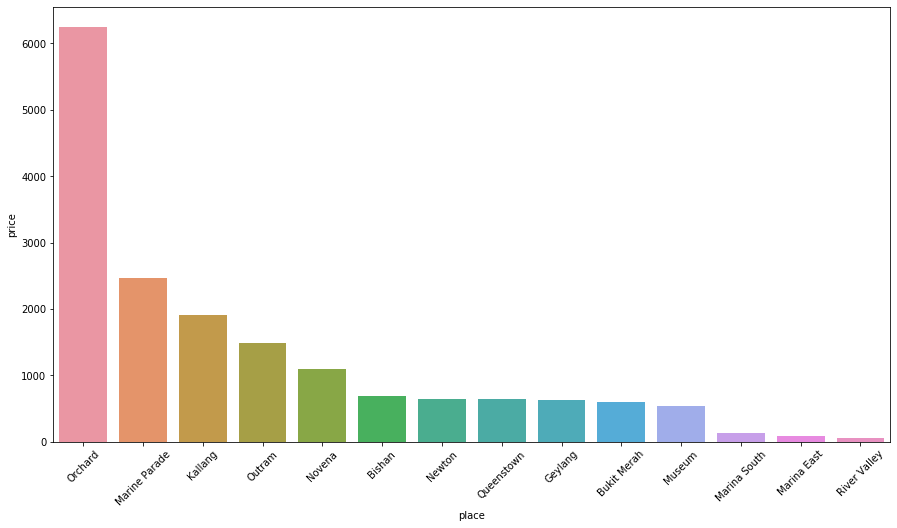

In [29]:
plt.figure(figsize=(15,8))
sns.barplot(x=dfFullGrouped.index,y=dfFullGrouped['price']);
plt.xticks(rotation=45);
